### Import libraries

In [9]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from image_ops import *
from functools import reduce

### Example resizing an image

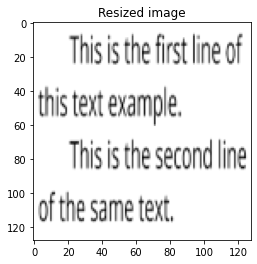

In [10]:
example_image_fp = '../data/sample_images/text_image.png'
# read image and convert it from BGR to Gray format
image = cv.cvtColor(cv2.imread(example_image_fp), cv2.COLOR_BGR2GRAY)

# interpolation is one of cv2.INTER_* (e.g INTER_NEAREST, INTER_LINEAR, INTER_CUBIC, etc)
degr_pipeline = [ResizeOperation(128, 128, interpolation=cv.INTER_CUBIC)]

resized = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(resized, cmap='gray')
plt.title('Resized image');

### Example adding noise to an image

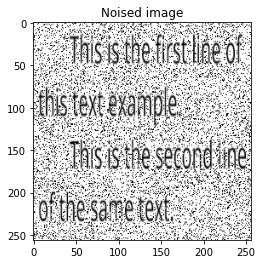

In [13]:
degr_pipeline = [GaussianNoiseOperation(), SaltPepperOperation()]

# noise_type is one of SALT_AND_PEPPER, GAUSSIAN
noised = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(noised, cmap='gray')
plt.title('Noised image');

### Levenshtein distance

In [14]:
from metrics import edit_distance

    
print(edit_distance('cat', 'dog'))
print(edit_distance('kelm', 'hello'))
print(edit_distance('ab', 'ba'))
print(edit_distance('ab', 'ba'))

3.0
3.0
2.0
2.0


In [15]:
import pytesseract as tesseract


# specify path to the preinstalled binary file of tesseract
tesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

print('Tesseract version: ', tesseract.get_tesseract_version())

outp_text = tesseract.image_to_string(noised)
gt_text = 'This is the first line of\nthis text example. This is the second line\nof the same text.'
print('Ground truth text:', repr(gt_text))
print('Recognized text:', repr(outp_text))
print('Edit distance between the two:', edit_distance(gt_text, outp_text))

Tesseract version:  5.0.0-alpha.20200328
Ground truth text: 'This is the first line of\nthis text example. This is the second line\nof the same text.'
Recognized text: ' \n\x0c'
Edit distance between the two: 84.0


In [16]:
psnr_fig = cv.PSNR(image, noised)
print('PSNR', psnr_fig)

PSNR 8.733227555929219


### Example bluring an image

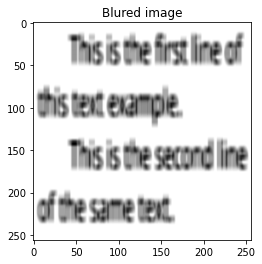

In [21]:
degr_pipeline = [BoxBlurOperation(radius=3)]

blured = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(blured, cmap='gray')
plt.title('Blured image');

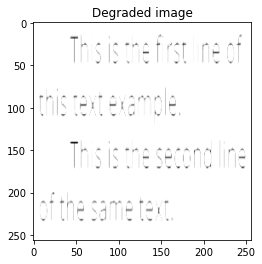

In [24]:
degr_pipeline = [MaxFilterOperation(radius=3)]

degraded = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(degraded, cmap='gray')
plt.title('Degraded image');

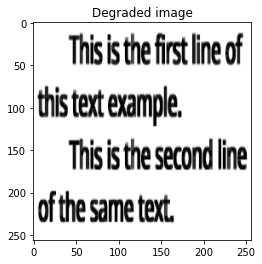

In [25]:
degr_pipeline = [MinFilterOperation(radius=3)]

degraded = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(degraded, cmap='gray')
plt.title('Degraded image');

### Example rotating an image

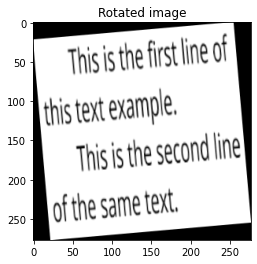

In [27]:
degr_pipeline = [RotateOperation(angle=5, center=(256 // 2, 256 // 2))]

rotated = reduce(lambda image, op: op(image), degr_pipeline, image)
plt.imshow(rotated, cmap='gray')
plt.title('Rotated image');

(34, 43) (56, 65)
(67, 22) (77, 100)
(21, 27) (35, 41)
(42, 14) (48, 62)


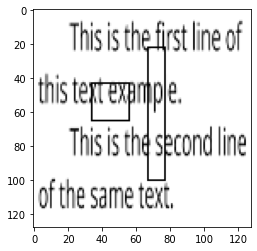

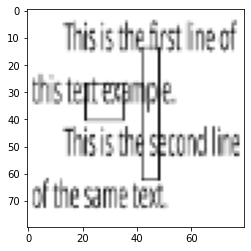

In [66]:
orig_bboxes = (
    [(34, 43), (56, 65)],
    [(67, 22), (77, 100)]
)
orig_bboxes

temp_img = np.copy(image)
for pt1, pt2 in orig_bboxes:
    print(pt1, pt2)
    cv2.rectangle(temp_img, pt1, pt2, (0, 255, 0), 1)

plt.imshow(temp_img, cmap='gray'), temp_img.shape

plt.figure()
    
    
resized = cv2.resize(temp_img, (80, 80))

def scale_bounding_boxes(original_size, target_size, bounding_boxes):
    orig_width, orig_height = original_size
    new_width, new_height = target_size

    for (orig_x1, orig_y1), (orig_x2, orig_y2) in orig_bboxes:
        x1_ratio, y1_ratio = orig_x1 / orig_width, orig_y1 / orig_height
        x1_new, y1_new = x1_ratio * new_width, y1_ratio * new_height

        x2_ratio, y2_ratio = orig_x2 / orig_width, orig_y2 / orig_height
        x2_new, y2_new = x2_ratio * new_width, y2_ratio * new_height

        yield [(round(x1_new), round(y1_new)), (round(x2_new), round(y2_new))]


new_bboxes = list(scale_bounding_boxes(temp_img.shape[:2], resized.shape[:2], orig_bboxes))

plt.imshow(resized, cmap='gray')

for pt1, pt2 in new_bboxes:
    print(pt1, pt2)
    cv2.rectangle(resized, pt1, pt2, (0, 255, 0), 1)

In [100]:
def rotate_point2d(src_point, pivot_point, angle, radians=False):
    if not radians:
        angle *= np.pi / 180
        
    (x1, y1), (x0, y0) = src_point, pivot_point
    x2 = ((x1 - x0) * np.cos(angle)) - ((y1 - y0) * np.sin(angle)) + x0
    y2 = ((x1 - x0) * np.sin(angle)) + ((y1 - y0) * np.cos(angle)) + y0

    return x2, y2

rotate_point2d((15, 5), (2,2), 45)

(9.071067811865476, 13.313708498984763)

(32, 43)
(53, 66)
(66, 24)
(72, 102)


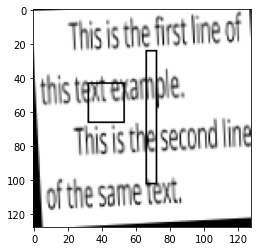

In [112]:

rotate_op = RotateOperation(angle=3, center=(20, 20))
rotated = rotate_op(image)
for pt1, pt2 in orig_bboxes:
    rotated_p1 = tuple(int(d) for d in rotate_point2d(pt1, (20, 20), 3, ))
    rotated_p2 = tuple(int(d) for d in rotate_point2d(pt2, (20, 20), 3,))
    print(rotated_p1)
    print(rotated_p2)
    cv2.rectangle(rotated, rotated_p1, rotated_p2, (0, 255, 0), 1)
    
plt.imshow(rotated, cmap='gray')

(31, 44)
(50, 69)
(66, 27)
(66, 106)


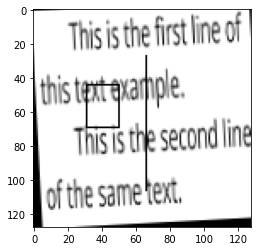

In [111]:

rotate_op = RotateOperation(angle=3, center=(20, 20))
rotated = rotate_op(image)
for pt1, pt2 in orig_bboxes:
    rotated_p1 = tuple(int(d) for d in rotate_point2d(pt1, (20, 20), 7, ))
    rotated_p2 = tuple(int(d) for d in rotate_point2d(pt2, (20, 20), 7,))
    print(rotated_p1)
    print(rotated_p2)
    cv2.rectangle(rotated, rotated_p1, rotated_p2, (0, 255, 0), 1)
    
plt.imshow(rotated, cmap='gray')